## Prophet

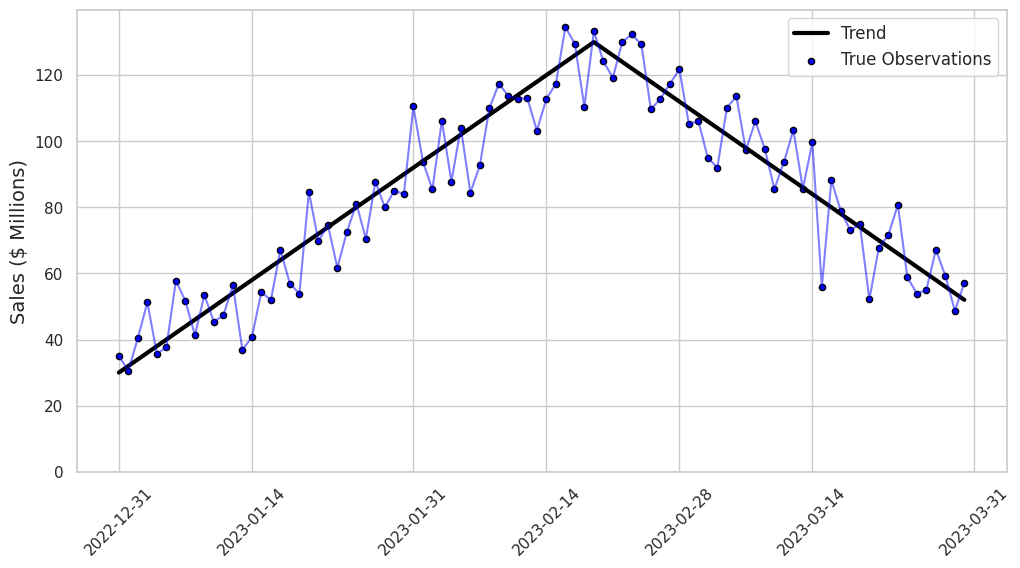

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 Seaborn 设置图表风格
sns.set(style="whitegrid")

# 生成带噪声的上三角趋势时间序列（横坐标改为日期）
def generate_triangle_trend_with_noise(n=90, t_peak=50, noise_scale=10, start_date="2023-01-01"):
    np.random.seed(42)
    dates = pd.date_range(start=start_date, periods=n)  # 生成日期范围
    
    # 生成主趋势（上三角形）
    trend = np.piecewise(
        np.arange(n),
        [np.arange(n) < t_peak, np.arange(n) >= t_peak],
        [lambda t: 2 * t,  # 上升阶段
         lambda t: 200 - 2 * t]  # 下降阶段
    )
    
    # 在每个时间点生成一个带噪声的观测值
    noise = np.random.normal(loc=0, scale=noise_scale, size=n)  # 控制噪声幅度
    noisy_series = trend + noise + 30 # 观测值 = 趋势 + 噪声

    return dates, trend, noisy_series

# 生成数据
dates, trend, noisy_series = generate_triangle_trend_with_noise()

# 绘制图形
plt.figure(figsize=(12, 6))

# 绘制主趋势线（上三角形）
plt.plot(dates, trend + 30, color='black', linewidth=3, label="Trend")

# 绘制带噪声的时间序列（散点组成的曲线）
plt.scatter(dates, noisy_series, color='blue', edgecolors='black', label="True Observations", s=20)
plt.plot(dates, noisy_series, color='blue', alpha=0.5, linewidth=1.5)

# 美化图表
# plt.title("Triangle Trend with Noisy Time Series", fontsize=16)
# plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales ($ Millions)", fontsize=14)
plt.ylim(bottom=0)
plt.xticks(rotation=45)  # 旋转日期刻度
plt.legend(fontsize=12)
plt.show()


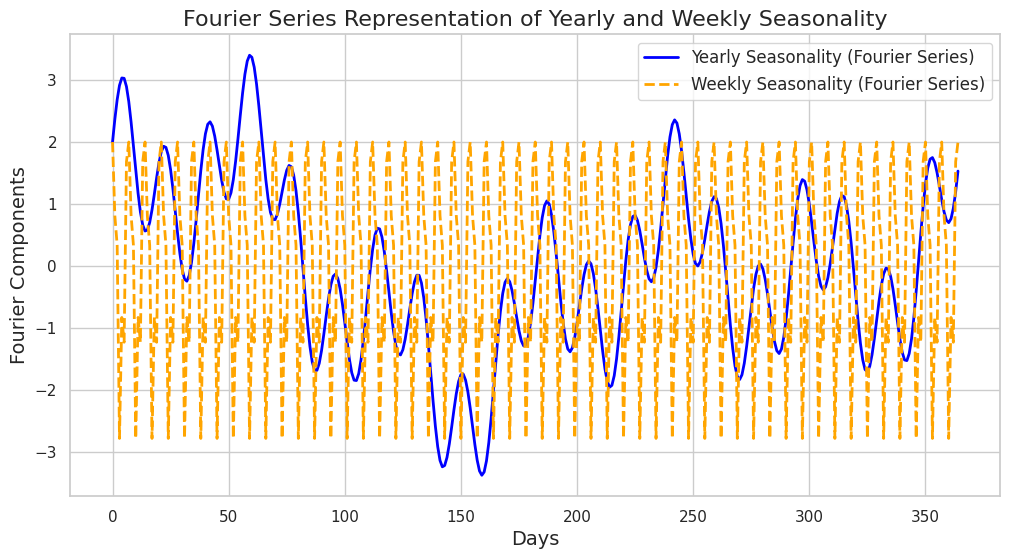

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 Seaborn 设置图表风格
sns.set(style="whitegrid")

# 生成时间序列数据
days = np.arange(0, 365, 1)  # 一年 365 天
omega = 2 * np.pi / 365.25  # 年周期频率
omega_week = 2 * np.pi / 7  # 周周期频率

# 计算 Fourier 变量
fourier_yearly = np.cos(omega * days) + np.sin(2 * omega * days) + np.cos(6 * omega * days) + np.sin(20 * omega * days)
fourier_weekly = np.cos(omega_week * days) + np.sin(4 * omega_week * days) + np.cos(6 * omega_week * days)

# 绘制可视化
plt.figure(figsize=(12, 6))

# 年周期 Fourier 分解
plt.plot(days, fourier_yearly, label="Yearly Seasonality (Fourier Series)", color="blue", linewidth=2)
# 周周期 Fourier 分解
plt.plot(days, fourier_weekly, label="Weekly Seasonality (Fourier Series)", color="orange", linewidth=2, linestyle="dashed")

# 添加图例和标签
plt.title("Fourier Series Representation of Yearly and Weekly Seasonality", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Fourier Components", fontsize=14)
plt.legend(fontsize=12)
plt.show()


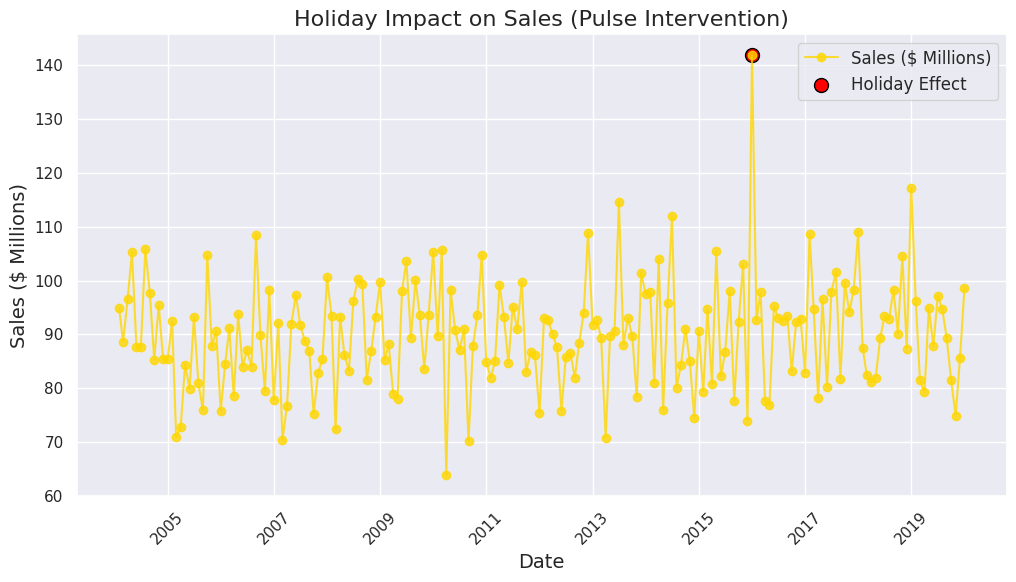

In [39]:
# 生成一个时间序列数据，其中某个假期（如12/2016）导致销量突增

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 Seaborn 设置图表风格
sns.set(style="darkgrid")

# 生成时间范围（从 2005 到 2021 年，每月一个数据点）
dates = pd.date_range(start="2005-01-01", end="2021-01-01", freq='M')

# 生成基础销售数据（带有随机波动）
np.random.seed(42)
sales = np.random.normal(loc=90, scale=10, size=len(dates))  # 正常销售波动

# 添加假日干预点（例如在 2016 年 12 月的销量突增）
holiday_index = np.where((dates.year == 2016) & (dates.month == 12))[0][0]
sales[holiday_index] += 50  # 增加突发销量

# 生成假日变量
holiday_variable = np.zeros(len(dates))
holiday_variable[holiday_index] = 1  # 只有 2016 年 12 月有假日影响

# 绘制时间序列
plt.figure(figsize=(12, 6))
plt.plot(dates, sales, marker='o', linestyle='-', color='gold', alpha=0.8, label="Sales ($ Millions)")

# 标记假期影响点
plt.scatter(dates[holiday_index], sales[holiday_index], color='red', s=100, label="Holiday Effect", edgecolors='black')

# 美化图表
plt.title("Holiday Impact on Sales (Pulse Intervention)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales ($ Millions)", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.show()


23:11:16 - cmdstanpy - INFO - Chain [1] start processing


23:11:16 - cmdstanpy - INFO - Chain [1] done processing


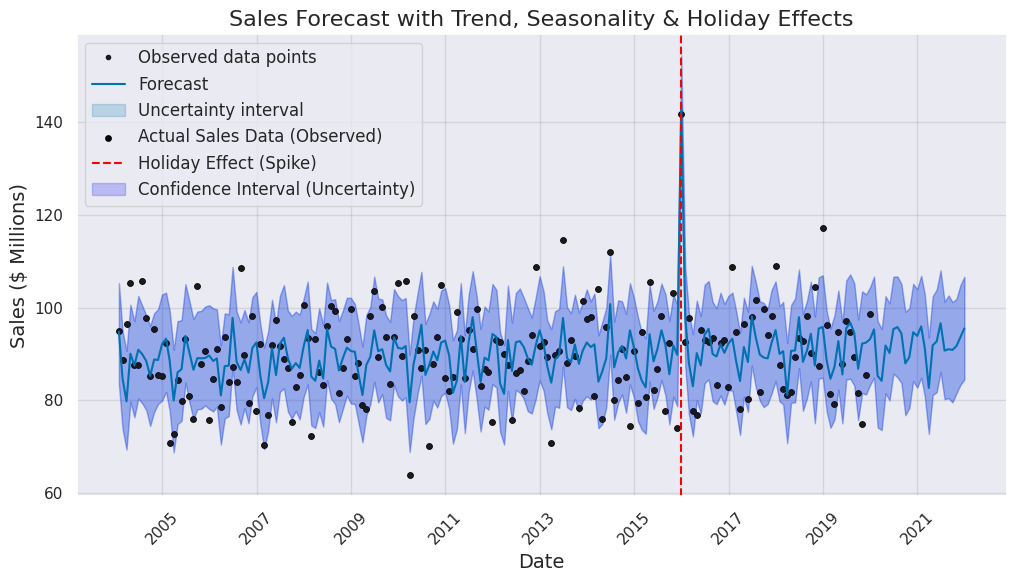

In [50]:
# 重新绘制 Prophet 预测图，并添加详细的图例标注

from prophet import Prophet

# 创建 DataFrame（Prophet 需要 "ds" 作为日期，"y" 作为目标值）
df = pd.DataFrame({"ds": dates, "y": sales})

# 添加假日变量
holidays = pd.DataFrame({
    'holiday': 'special_event',
    'ds': [dates[holiday_index]],  # 2016年12月的假日影响
    'lower_window': 0,
    'upper_window': 1,
})

# 初始化 Prophet 模型，包含趋势、季节性和假日效应
model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
model.fit(df)

# 生成未来 2 年的预测数据
future = model.make_future_dataframe(periods=24, freq='M')  # 未来 24 个月
forecast = model.predict(future)

# 绘制 Prophet 预测图
fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)

# 添加详细的标注
ax.scatter(df["ds"], df["y"], color="black", label="Actual Sales Data (Observed)", s=15)  # 真实观测点
ax.axvline(dates[holiday_index], color="red", linestyle="--", label="Holiday Effect (Spike)")  # 假日效应
ax.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], 
                color="blue", alpha=0.2, label="Confidence Interval (Uncertainty)")

# 添加标题和图例
ax.set_title("Sales Forecast with Trend, Seasonality & Holiday Effects", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Sales ($ Millions)", fontsize=14)
ax.legend(fontsize=12)

plt.xticks(rotation=45)
plt.show()


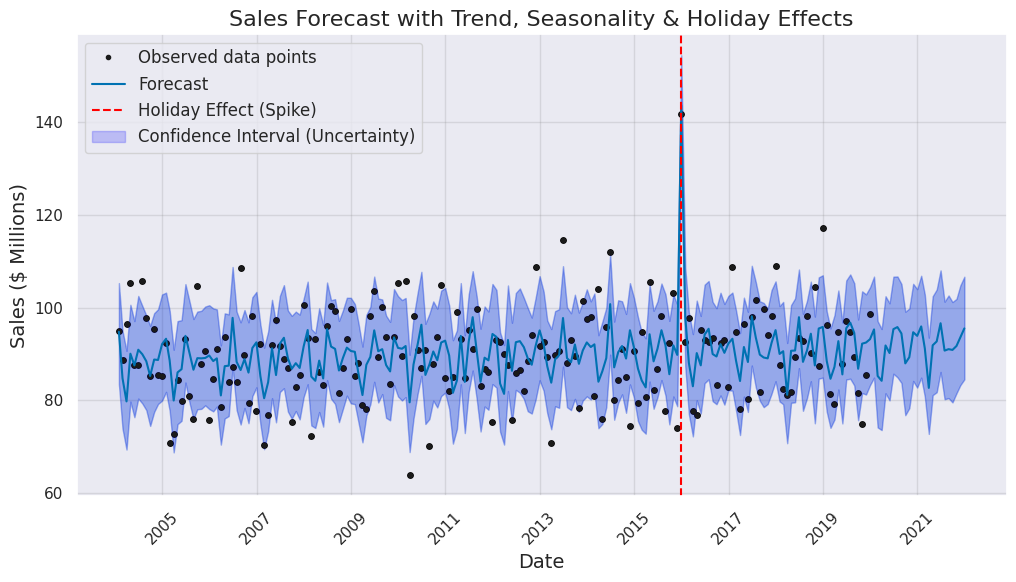

In [58]:
# 重新绘制 Prophet 预测图，移除 "Observed data points" 和 "Uncertainty interval" 的图例

fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)

# 只保留关键图例项
ax.scatter(df["ds"], df["y"], color="black", s=15)  # 真实观测点，但不在图例中显示
ax.axvline(dates[holiday_index], color="red", linestyle="--", label="Holiday Effect (Spike)")  # 假日效应
ax.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], 
                color="blue", alpha=0.2, label="Confidence Interval (Uncertainty)")

# 重新设置图例，仅保留 Forecast, Holiday Effect, Confidence Interval
handles, labels = ax.get_legend_handles_labels()
filtered_handles = [handles[0], handles[1], handles[3], handles[4]]  # 只保留 Forecast, Holiday Effect, Confidence Interval
filtered_labels = [labels[0], labels[1], labels[3], labels[4]]

ax.legend(filtered_handles, filtered_labels, fontsize=12)

# 添加标题和标签
ax.set_title("Sales Forecast with Trend, Seasonality & Holiday Effects", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Sales ($ Millions)", fontsize=14)

plt.xticks(rotation=45)
plt.show()
